# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# Import libraries here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

In [2]:
!pip install xgboost
import xgboost as xgb

In [3]:
import os
os.getcwd()

'C:\\Users\\akash\\Desktop\\Capstone Project'

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Load and Explore the Data

In [4]:
# load in the data
azdias = pd.read_csv('C:/Users/akash/Desktop/Capstone Project/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('C:/Users/akash/Desktop/Capstone Project/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\akash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
del azdias['Unnamed: 0']
del customers['Unnamed: 0']
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
# Shape of data
azdias.shape

(891221, 366)

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


# Data Preprocessing and Cleaning

In [8]:
# check object features which we need to convert or remove from the database for PCA
df_object = azdias.select_dtypes(include='object')
df_object.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [9]:
# remove extra columns from customers data
customers_extra_columns=set(customers.columns.tolist())-set(azdias.columns.tolist())
print(customers_extra_columns)
customers.drop(customers_extra_columns,axis=1, inplace=True)

{'PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'}


In [10]:
# remove columns which have more than 20% missing data
percent_null_count = (azdias.isnull().sum()/len(azdias))*100
percent_missing_over20 = percent_null_count[percent_null_count>20]
missing20_col_names=percent_missing_over20.index.tolist()

In [11]:
missing20_col_names

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [12]:
# Creating clean data function

In [13]:
def clean_data(data):
    
    # Remove columns which have more than 20% missing data
    
    data=data.drop(missing20_col_names,axis=1)
    
    data['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)
    data['VERS_TYP'].replace([1, 2], [1, 0], inplace=True)
    data['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    # Create two new variables using CAMEO_INTL_2015
    
    data['CAMEO_INTL_2015_WEALTH'] = data['CAMEO_INTL_2015']
    data['CAMEO_INTL_2015_LIFESTAGE'] = data['CAMEO_INTL_2015']
    data = data.drop('CAMEO_INTL_2015', axis=1)
    
    wealth_des = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2,
               31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4,
               51:5, 52:5, 53:5, 54:5, 55:5,51:5,'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5,'XX':-1}

    lifestage_des = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5,
                   31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5,
                   51:1, 52:2, 53:3, 54:4, 55:5,'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5,'XX':-1}
    
    group_class = {1:1,2:1,3:2,4:2,5:2,6:3,7:3,8:4,9:4,'1':1,'2':1,'3':2,'4':2,'5':2,'6':3,'7':3,'8':4,'9':4,'X':-1}

    data['CAMEO_INTL_2015_WEALTH'].replace(wealth_des, inplace=True)
    data['CAMEO_INTL_2015_LIFESTAGE'].replace(lifestage_des, inplace=True)
    data['CAMEO_DEUG_2015'].replace(group_class, inplace=True)
    
    data['PRAEGENDE_DECADE'] = data['PRAEGENDE_JUGENDJAHRE']
    data = data.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Change coding for PRAEGENDE_DECADE
    
    decade_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    
    data['PRAEGENDE_DECADE'].replace(decade_dic, inplace=True)
    
    data=pd.get_dummies(data, columns=['CAMEO_DEU_2015'])
    
    # Remove LNR and EINGEFUEGT_AM from the database
    
    data.drop(['LNR','EINGEFUEGT_AM'], axis=1, inplace=True)
    
    return data

In [35]:
customer=clean_data(customers)

# Remove rows which have missing data for more than 10 columns    
missing_row=customer.isnull().sum(axis=1)
customer=customer[missing_row < 11]

In [36]:
# Select 100% of Azdias dataset
azdias_sample = azdias.sample(frac=1, random_state=23)
azdias_sample.shape

(891221, 366)

In [37]:
azdias_sample = clean_data(azdias_sample)
# Remove rows which have missing data for more than 10 columns    
missing_row=azdias_sample.isnull().sum(axis=1)
azdias_sample=azdias_sample[missing_row < 11]

In [38]:
print('Shape of Azdias Dataset:', azdias_sample.shape)
print('Shape of Customer Dataset:', customer.shape)

Shape of Azdias Dataset: (746781, 393)
Shape of Customer Dataset: (132101, 393)


# Part 1: Customer Segmentation Report

The main bulk of my analysis will come in this part of the project. Here, I will use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, we should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

First we will use imputer function for imputing missing values then we will do the feature scaling so that the principal componenet verctors does not get affected when applying pca to reduce the dimensionality. 

In [18]:
# Impute the Nans
imputer = Imputer()
azdias_data = imputer.fit_transform(azdias_sample)

C:\Users\akash\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
# Apply feature scaling
scaler = StandardScaler()
azdias_data = scaler.fit_transform(azdias_data)

# Perform Dimensionality Reduction

After applying principal component analysis on the database we need to check the ratio of variance explained by each principal component as well as the cumulative variance explained. We need to choose few transformed features for the clustering part of the project.

In [20]:
# Apply PCA
pca = PCA(200)
pca_azdias = pca.fit_transform(azdias_data)

In [21]:
# Plot the variance explained by each principal component.

def principal_component_plot(pca):
    '''
    INPUT: pca - Result of PCA
            
    OUTPUT: None
    
    '''
    num_comp = len(pca.explained_variance_ratio_)
    indicator = np.arange(num_comp)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(indicator, vals)
    ax.plot(indicator, cumvals)
    for i in range(num_comp):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (indicator[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

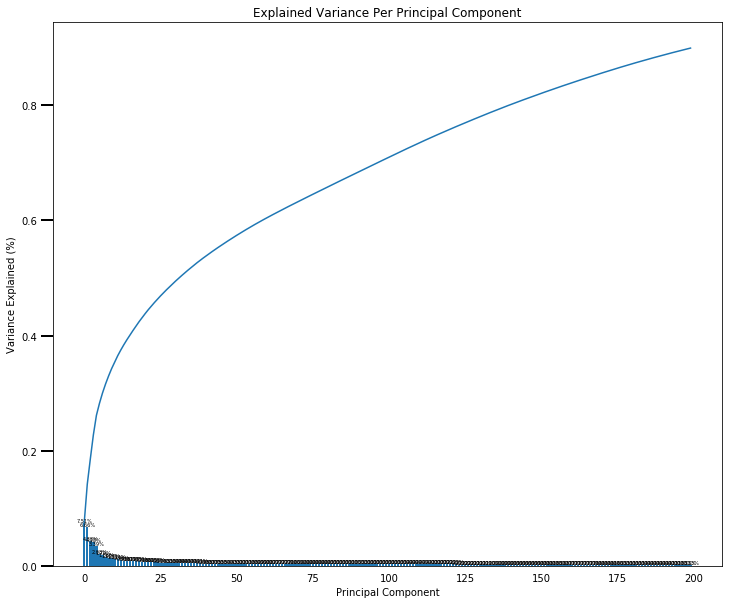

In [22]:
principal_component_plot(pca)

We reduced the component to 200 by applying PCA, which is around half of total features, the result contains over 85% of total information. We can reduce these components furthur to capture the 70% information with this method.

In [23]:
pca = PCA(110)
pca_azdias = pca.fit_transform(azdias_data)

In [24]:
sum(pca.explained_variance_ratio_)

0.7272401888255023

# Component Makeup

We can now examine the make up of each PCA component based on the weightings of the original features that are included in the component. The following code shows the feature level makeup of the first component.

In [25]:
features_list = azdias_sample.columns.values

In [26]:
v=pd.DataFrame(pca.components_)

In [27]:
def display_component(v,features_list,component_num,n_weights = 10):
    
    # get the list of weights     
    v_1_row = v.iloc[component_num-1,:]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)),columns=['weights', 'features'])

    # Sort by the largest weights
    # weights can be neg/pos and we'll sort by magnitude
    
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

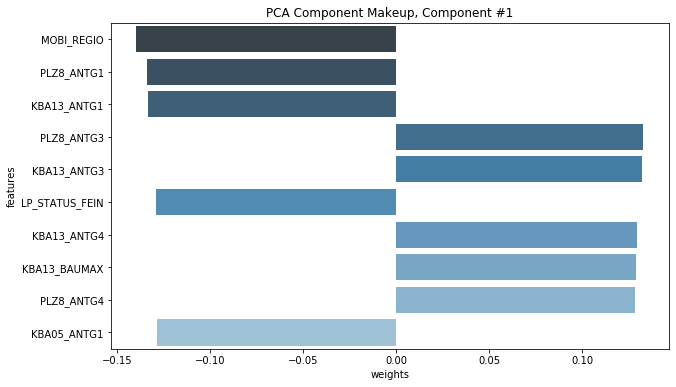

In [28]:
num=1
display_component(v,features_list,component_num=num,n_weights = 10)

# K-Means Clustering

We will do the clustering by using K-means estimator. K is such that data points in a single cluster are close together but that there are enough clusters to effectively separate the data. We can approximate this separation by measuring how close our data points are to each cluster center; the average centroid distance between cluster points and a centroid. After trying several values for k, the centroid distance typically reaches some "elbow"; it stops decreasing at a sharp rate and this indicates a good value of k. We will find out this value by plotting the graph between k and score.

In [29]:
score = []

for i in range(18, 32, 2):
    
    begin = time.time()
    kmean = KMeans(i)
    kmean = kmean.fit(pca_azdias)
    score.append(np.abs(kmean.score(pca_azdias)))
    
    # compute the average within-cluster distances.
    end = time.time()
    print('time cost for k=', str(i), ' the calculation time is ', end-begin, 's')

time cost for k= 18  the calculation time is  1541.7918963432312 s
time cost for k= 20  the calculation time is  1219.0834827423096 s
time cost for k= 22  the calculation time is  1397.8556261062622 s
time cost for k= 24  the calculation time is  1266.3224182128906 s
time cost for k= 26  the calculation time is  1498.2392835617065 s
time cost for k= 28  the calculation time is  1348.0845880508423 s
time cost for k= 30  the calculation time is  1585.3306150436401 s


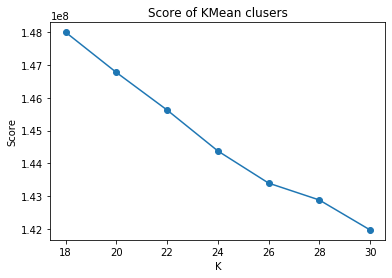

In [30]:
# Plot change in within-cluster distance vs number of clusters

plt.plot(range(18, 32, 2), score, marker='o', linestyle='-')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Score of KMean clusers')
plt.show()

In [46]:
begin = time.time()
kmean = KMeans(30)
kmean = kmean.fit(pca_azdias)
print(np.abs(kmean.score(pca_azdias)))
end = time.time()
print('time cost for the calculation is ', end-begin, 's')

141821610.0458409
time cost for the calculation is  1514.5597758293152 s


In [47]:
predict_azdias = kmean.predict(pca_azdias)

In [48]:
# Apply imputer, scaler, and pca transform to customer dataset then predict the data with kmean cluster 
customers_data = imputer.transform(customer)
customers_data = scaler.transform(customers_data)
pca_customers= pca.transform(customers_data)
predict_customers = kmean.predict(pca_customers)

# Comapre customers data with demographics data

Now we have clustered data based on demographics of the general population of Germany and the customer data for a mail-order sales company which has been mapped onto those demographic clusters. In this final step, the two cluster distributions will be compared to see where the strongest customer base for the company is.

If we assume that company's customer base is universal then cluster's distribution should be similar to general population. If there are any mismatch between these two groups that means that particular segment is more interested in company's products. If there are high proportions of customers belong to the particular cluster for the customer data compared to general population that means people in that cluster is the target audience for the company. If its other way around that means population belongs to that cluster is not the right audience for the company.

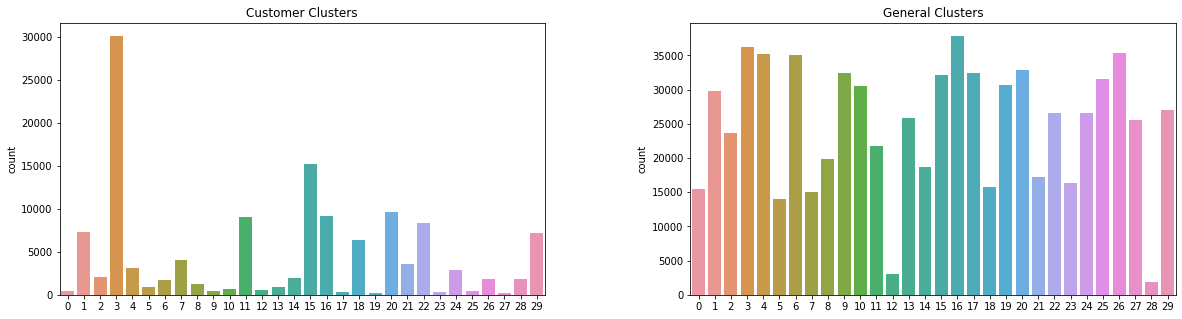

In [49]:
# Compare the proportion of data in each cluster for the customer data and general population data.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(predict_customers, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(predict_azdias, ax=axs[1])
axs[1].set_title('General Clusters')
plt.show()

In [50]:
np.bincount(predict_customers)/len(predict_customers)*100

array([ 0.33686346,  5.52077577,  1.54502994, 22.79770781,  2.35198825,
        0.66918494,  1.27175419,  3.06886398,  0.94775967,  0.35503138,
        0.49204775,  6.83643576,  0.44208598,  0.72066071,  1.47538626,
       11.49650646,  6.96663916,  0.26570579,  4.80465704,  0.14231535,
        7.2876057 ,  2.70853362,  6.31032316,  0.23845391,  2.20513092,
        0.35730237,  1.38454667,  0.16881023,  1.35880879,  5.47308499])

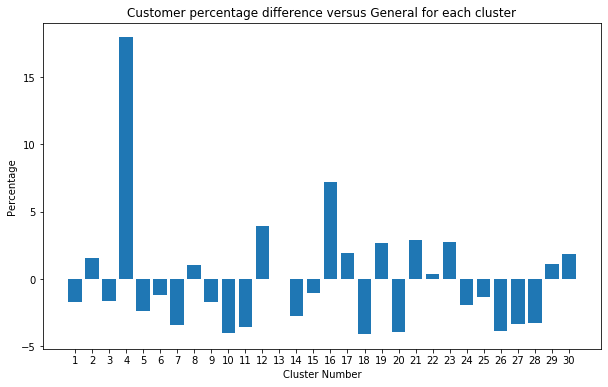

[-1.7325518   1.52669986 -1.63153722 17.93764844 -2.35849581 -1.20258202
 -3.41864367  1.04859297 -1.70683385 -3.98439343 -3.60513737  3.91697209
  0.02964913 -2.74675477 -1.01731241  7.19069257  1.89835274 -4.08617248
  2.69158775 -3.97120655  2.88939524  0.40330625  2.74783295 -1.95201425
 -1.34611101 -3.86535461 -3.35352245 -3.25562076  1.10090185  1.85261259]


In [54]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.bar(range(1, 31), np.bincount(predict_customers)/len(predict_customers)*100 - np.bincount(predict_azdias)/len(predict_azdias)*100)
ax.set_title('Customer percentage difference versus General for each cluster')
ax.set_ylabel('Percentage')
ax.set_xlabel('Cluster Number')
ax.set_xticks(range(1, 31))
plt.show()
print(np.bincount(predict_customers)/len(predict_customers)*100 - np.bincount(predict_azdias)/len(predict_azdias)*100)

In [55]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
            pca.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
            columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

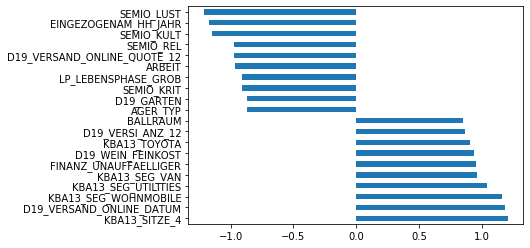

In [59]:
plot_scaled_comparison(customers, kmean, 3)

In [60]:
# check the component values of each cluster, 

def cluster_centers(cluster, features):
    cluster_center = np.around(kmean.cluster_centers_[cluster-1], decimals=2)
    clusters_sorted = cluster_center[np.argsort(cluster_center)[:]]
    pca_pre = np.around(pca.inverse_transform(kmean.cluster_centers_[cluster-1]), decimals=2)
    pca_pre_index = np.argsort(pca_pre)
    pca_pre_sorted = pca_pre[np.argsort(pca_pre)[:]]
    print('Cluster %s' % cluster)
    print('sorted array\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(clusters_sorted[-3:],0), clusters_sorted[:3]))
    print('\n original array\n-----\n %s'% cluster_center)
    
    print('PCA sorted\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(pca_pre_sorted[-3:],0), pca_pre_sorted[:3]))
    print('\n pre PCA is \n-----\n %s'% pca_pre)
    print('\n Top three correlated features are \n-----\n %s '% features[pca_pre_index[0]], \
          features[pca_pre_index[1]], features[pca_pre_index[2]])
    print('\n Top three negative correlated features are \n-----\n %s'% features[pca_pre_index[-1]], \
          features[pca_pre_index[-2]], features[pca_pre_index[-3]])

In [62]:
features_pre = list(azdias_sample.columns.values)
cluster_centers(4, features_pre)

Cluster 4
sorted array
-----
 Top 3: [2.84 1.04 0.38] 
 Bottom 3: [-6.62 -1.31 -1.16] 

 original array
-----
 [-6.62  1.04 -1.31 -0.33  2.84 -0.94  0.29  0.38  0.09 -0.45 -0.62 -1.16
  0.17 -0.3   0.16  0.22 -0.64  0.07 -0.13  0.1   0.19 -0.04 -0.19 -0.08
  0.03  0.28 -0.02  0.28 -0.17  0.11 -0.35 -0.16 -0.2  -0.12 -0.26 -0.14
  0.16 -0.16  0.3  -0.35 -0.    0.09  0.16  0.01 -0.1   0.02 -0.06  0.31
 -0.03 -0.1   0.16  0.    0.05 -0.08 -0.09 -0.19  0.04  0.21 -0.08 -0.01
  0.04 -0.06 -0.03  0.04 -0.04  0.01 -0.03 -0.05  0.07 -0.05 -0.06  0.
 -0.08  0.01  0.04 -0.    0.05 -0.01 -0.01  0.02  0.01  0.08 -0.03  0.01
 -0.04 -0.05 -0.05  0.01 -0.08  0.02  0.01 -0.07  0.04  0.01  0.02  0.08
  0.05  0.01  0.07  0.09  0.03 -0.08  0.    0.06  0.14  0.06  0.06  0.04
 -0.05  0.  ]
PCA sorted
-----
 Top 3: [1.21 1.18 1.16] 
 Bottom 3: [-1.21 -1.18 -1.15] 

 pre PCA is 
-----
 [ 0.82 -0.87  0.21 -0.44 -0.12 -0.06  0.73 -0.43 -0.01 -0.47  0.22 -0.84
 -0.24  0.05 -0.84 -0.96  0.85  0.67  0.84  0.71 -0

In [63]:
# customer data compared to the general population?
cluster_centers(18, features_pre)

Cluster 18
sorted array
-----
 Top 3: [1.65 1.2  0.98] 
 Bottom 3: [-4.51 -2.86 -2.8 ] 

 original array
-----
 [ 1.65 -0.89  0.94 -2.8  -4.51  1.2  -2.86  0.98 -0.2   0.1  -0.28 -0.36
  0.17  0.08 -0.2   0.01 -0.1  -0.16 -0.02 -0.18 -0.22 -0.33  0.37  0.08
  0.15 -0.04  0.25 -0.07 -0.2   0.1  -0.41  0.05 -0.17  0.05 -0.03 -0.22
  0.15  0.04 -0.06 -0.14 -0.08  0.06 -0.04 -0.02  0.02 -0.14  0.05 -0.03
  0.15 -0.08 -0.05  0.05  0.    0.04 -0.06 -0.02 -0.07 -0.08 -0.02  0.14
 -0.04 -0.07  0.03  0.07  0.1   0.07  0.    0.   -0.04  0.01  0.02 -0.01
  0.   -0.   -0.02  0.    0.04  0.03 -0.06 -0.03  0.01  0.05 -0.    0.02
  0.01 -0.   -0.01  0.03 -0.04  0.03 -0.06 -0.05 -0.    0.04  0.09 -0.03
  0.07 -0.05 -0.01 -0.01  0.04  0.02 -0.04 -0.01  0.02  0.12 -0.   -0.04
 -0.01 -0.01]
PCA sorted
-----
 Top 3: [1.24 1.21 1.08] 
 Bottom 3: [-1.18 -1.12 -1.09] 

 pre PCA is 
-----
 [-0.63  0.64  0.09 -0.04 -0.07  0.   -0.36 -0.05 -0.05 -0.11 -0.06 -0.05
  0.33 -0.94  1.21  1.08 -1.12 -0.82 -1.02 -1.18

# Conclusion - Unsupervised Learning Findings

First we counted the data points of each cluster for general population and company's customer database. We found out that cluster 4 has 17.94% higher customer percentage compared to general population and cluster 18 is underpresented with a difference of -4.1%. After that we analyzed the two clusters through inverse transformation of PCA.

For Cluster 4, we find that VK_ZG11, HH_EINKOMMEN_SCORE and VK_DISTANZ are the highest impacted feature. HH_EINKOMMEN_SCORE shows the income of a household which impacts the customer distribution, VK_ZG11 and VK_DISTANZ are not described in attributes file. Negative correlated features are LP_STATUS_GROB (Social status rough), FINANZ_MINIMALIST (Low Financial Interest) and LP_STATUS_FEIN (Social Status Fine) which shows better financial backed people are more likely to be a potential customer.
 
For cluster 18, highest impacted features are FINANZ_MINIMALIST (Low Financial Interest), CJT_TYP_6 (Not defined) and CJT_TYP_3 (Not defined). It shows that we should not target those people who have low financial interest. Negative correlated features are SEMIO_RAT, CJT_TYP_1 (Not defined) and CJT_TYP_2 (Not defined) which shows rational personality people are less likely to be the customer of the company.

# --------------------------------------------------------------------------------------------------------------

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

# Exploring the Data

In [ ]:
# Load train and test data
mailout_train = pd.read_csv('C:/Users/akash/Desktop/Capstone Project/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('C:/Users/akash/Desktop/Capstone Project/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [15]:
del mailout_train['Unnamed: 0']
del mailout_test['Unnamed: 0']
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [16]:
# Get y_train from training data
response = mailout_train['RESPONSE']
del mailout_train['RESPONSE']
len_train, len_test = len(mailout_train), len(mailout_test)
# Concat train and test data
train_test_data = pd.concat([mailout_train, mailout_test])

In [17]:
response.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [18]:
train_test_data.shape

(85795, 366)

The dataset is highly imbalanced because of the disproportionate amount of customers and non-customers as positive responses are only 1.23%.

# Data Cleaning

In [ ]:
def clean_data_new(data):
    
    # Remove columns which have more than 20% missing data
    
    percent_null_count = (data.isnull().sum()/len(azdias))*100
    percent_missing_over20 = percent_null_count[percent_null_count>20]
    missing20_col_names=percent_missing_over20.index.tolist()
    
    data=data.drop(missing20_col_names,axis=1)
    
    data['OST_WEST_KZ'].replace(['W','O'],[1,0],inplace=True)
    data['VERS_TYP'].replace([1, 2], [1, 0], inplace=True)
    data['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    # Create two new variables using CAMEO_INTL_2015
    
    data['CAMEO_INTL_2015_WEALTH'] = data['CAMEO_INTL_2015']
    data['CAMEO_INTL_2015_LIFESTAGE'] = data['CAMEO_INTL_2015']
    data = data.drop('CAMEO_INTL_2015', axis=1)
    
    wealth_des = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2,
               31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4,
               51:5, 52:5, 53:5, 54:5, 55:5,51:5,'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5,'XX':-1}

    lifestage_des = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5,
                   31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5,
                   51:1, 52:2, 53:3, 54:4, 55:5,'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5,'XX':-1}
    
    group_class = {1:1,2:1,3:2,4:2,5:2,6:3,7:3,8:4,9:4,'1':1,'2':1,'3':2,'4':2,'5':2,'6':3,'7':3,'8':4,'9':4,'X':-1}

    data['CAMEO_INTL_2015_WEALTH'].replace(wealth_des, inplace=True)
    data['CAMEO_INTL_2015_LIFESTAGE'].replace(lifestage_des, inplace=True)
    data['CAMEO_DEUG_2015'].replace(group_class, inplace=True)
    
    data['PRAEGENDE_DECADE'] = data['PRAEGENDE_JUGENDJAHRE']
    data = data.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    
    # Change coding for PRAEGENDE_DECADE
    
    decade_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    
    data['PRAEGENDE_DECADE'].replace(decade_dic, inplace=True)
    
    data=pd.get_dummies(data, columns=['CAMEO_DEU_2015'])
    
    # Remove LNR and EINGEFUEGT_AM from the database
    
    data.drop(['LNR','EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)
    
    return data

In [ ]:
# Call clean_data function to clean the data
train_test_data_clean = clean_data_new(train_test_data)
train_test_data_clean.shape

In [22]:
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
train_test_data_impute = imputer.fit_transform(train_test_data_clean)

C:\Users\akash\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [23]:
scaler = StandardScaler()
train_test_data_scaler = scaler.fit_transform(train_test_data_impute)

In [ ]:
# Split the dataset to train and test
train_data = train_test_data_scaler[:len_train]
test_data = train_test_data_scaler[len_train:]

# Modelling Data

Our data is highly imbalanced, using accuracy would not be ideal way to evaluate the model performance. Hence, we will use ROC_AUC to assess the model performance. 

In this project we will use the following models:

1) XGBRegressor
2) RandomForestRegressor
3) GradientBoostingClassifier

In [54]:
# Initialize the models
model_1 = XGBRegressor(objective='binary:logistic', random_state=1)
model_2 = RandomForestRegressor(random_state=1)
model_3 = GradientBoostingClassifier(random_state=1)

In [49]:
# randomize the data

def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation, :]
    Y2 = Y[permutation]
    
    return X2, Y2


X_train, y_train = randomize(np.asarray(train_data), np.asarray(response))

In [50]:
# Learning Curves

def learning_curves(X, y, estimator, title="Learning Curves"):
    
    X2, y2 = randomize(X, y)
    
    train_sizes = np.linspace(.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X2,
                                                            y2,
                                                            cv=5,
                                                            scoring='roc_auc',
                                                            n_jobs=-1,
                                                            train_sizes=train_sizes,
                                                            shuffle=True,
                                                            verbose=10
                                                           )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    plt.grid()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("AUC score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training Score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-Validation Score")

    plt.legend(loc="best")

    plt.show()

[learning_curve] Training set sizes: [ 3436  6873 10310 13747 17184 20621 24058 27495 30932 34369]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   39.6s remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  1.6min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  2.4min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  3.2min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  4.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  4.7min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  5.7min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  6.5min remaining:   43.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.2min finished


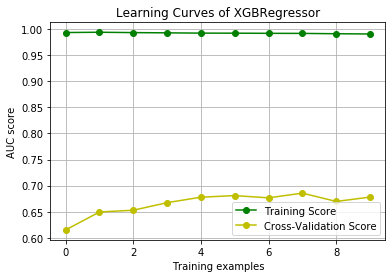

In [51]:
# XGBCRegressor
learning_curves(X_train, y_train, model_1,
                     title="Learning Curves of XGBRegressor")

[learning_curve] Training set sizes: [ 3436  6873 10310 13747 17184 20621 24058 27495 30932 34369]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   17.2s remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   58.2s remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  1.6min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  2.1min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  2.6min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  3.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  3.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  4.3min remaining:   28.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.6min finished


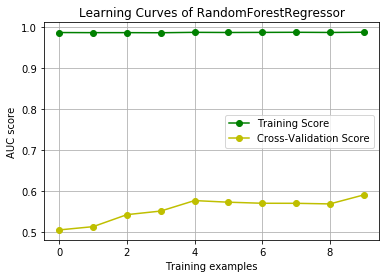

In [52]:
# RandomForestRegressor
learning_curves(X_train, y_train, model_2,
                     title="Learning Curves of RandomForestRegressor")

[learning_curve] Training set sizes: [ 3436  6873 10310 13747 17184 20621 24058 27495 30932 34369]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  2.1min remaining: 33.5min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  6.5min remaining: 29.8min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 10.8min remaining: 25.2min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 14.6min remaining: 20.2min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 18.3min remaining: 15.6min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 22.6min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 26.4min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 30.0min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 31.5min finished


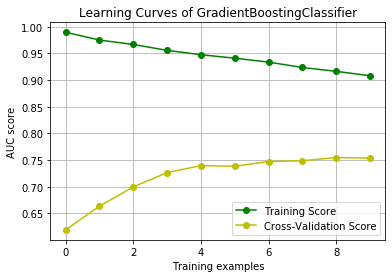

In [55]:
# GradientBoostingClassifier
learning_curves(X_train, y_train, model_3,
                     title="Learning Curves of GradientBoostingClassifier")

For GradientBoostingClassifier, training score keeps decreasing and cross-validation score keeps increasing. while for the other two models training score remains constant and the cross-validation score is low compared to GradientBoostingClassifier model. 

After analyzing all three models, we can say that GradientBoostingClassifier is the best model. 

# Parameter Tuning

Steps for Parameter Tuning:

1) First find out the optimum number of trees
2) Tune the learning rate and decide the optimal parameter.
3) Tune tree specific parameters (max_depth, min_samples_split and min_samples_leaf)

In [53]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # scoring roc_auc available as parameter
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    
    print('Best score: ', grid.best_score_)
    print('Best params: ', grid.best_params_)
    
    return grid.best_estimator_

# Find the number of estimators

In [61]:
clf = GradientBoostingClassifier(random_state=1)

# use gridsearch to find best fitted model

parameters = {
    'n_estimators': range(5,30,5)
             }


best_predicter = grid_search(clf, parameters, X_train, y_train)

Best score:  0.7622396161096848
Best params:  {'n_estimators': 15}


# Tune Learning Rate

In [62]:
clf = GradientBoostingClassifier(random_state=1)

# use gridsearch to find best fitted model

parameters = {
    'n_estimators': [15],
    'learning_rate':[0.001, 0.01, 0.05, 0.1]           
             }


best_predicter = grid_search(clf, parameters, X_train, y_train)

Best score:  0.7622396161096848
Best params:  {'learning_rate': 0.1, 'n_estimators': 15}


# Tune max_depth, min_samples_split and min_samples_leaf

In [63]:
clf = GradientBoostingClassifier(random_state=1)

# use gridsearch to find best fitted model

parameters = {
            'n_estimators': [15],
            'learning_rate':[0.1],
            'max_depth': [5,6,7,8,9]
             }


best_predicter = grid_search(clf, parameters, X_train, y_train)

Best score:  0.7679420651987072
Best params:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 15}


In [70]:
clf = GradientBoostingClassifier(random_state=1)

# use gridsearch to find best fitted model

parameters = {
            'n_estimators': [15],
            'learning_rate':[0.1],
            'max_depth': [5],
            'min_samples_split':range(160,280,20)
             }


best_predicter = grid_search(clf, parameters, X_train, y_train)

Best score:  0.7593900999807008
Best params:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 220, 'n_estimators': 15}


In [72]:
clf = GradientBoostingClassifier(random_state=1)

# use gridsearch to find best fitted model

parameters = {
            'n_estimators': [15],
            'learning_rate':[0.1],
            'max_depth': [5],
            'min_samples_split':[220],
            'min_samples_leaf':range(30,71,10)
             }


best_predicter = grid_search(clf, parameters, X_train, y_train)

Best score:  0.7634379084047392
Best params:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 220, 'n_estimators': 15}


In [73]:
best_predicter

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=30, min_samples_split=220,
                           min_weight_fraction_leaf=0.0, n_estimators=15,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Now that we have created a model to predict which individuals are most likely to respond to a mailout campaign. It's time to test it on the test data. 



## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [74]:
mailout_test = pd.read_csv('C:/Users/akash/Desktop/Capstone Project/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\akash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
del mailout_test['Unnamed: 0']
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3


In [76]:
lnr = mailout_test['LNR']

In [77]:
result = best_predicter.predict_proba(test_data)
result

array([[0.96866474, 0.03133526],
       [0.97537722, 0.02462278],
       [0.99523503, 0.00476497],
       ...,
       [0.97061708, 0.02938292],
       [0.9680933 , 0.0319067 ],
       [0.98417529, 0.01582471]])

In [78]:
output = pd.DataFrame({'LNR':lnr, 'RESPONSE':result[:,0]})

In [79]:
output.head(5)

,LNR,RESPONSE
0,1754,0.968665
1,1770,0.975377
2,1465,0.995235
3,1470,0.995211
4,1478,0.978337


In [80]:
output.to_csv(path_or_buf='./result2.csv', index=False)